In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy
from keras.utils.vis_utils import plot_model

# Carga de datos

In [3]:
df = pd.read_csv('../data/PERU_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1995-03-01 to 2022-09-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PN02312FM  331 non-null    float64
 1   PD37974BM  331 non-null    float64
 2   PD37976BM  331 non-null    float64
 3   PN02028AM  331 non-null    float64
 4   PD37972BM  331 non-null    float64
 5   Class      331 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.1 KB


In [5]:
df.describe()

,PN02312FM,PD37974BM,PD37976BM,PN02028AM,PD37972BM,Class
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.007333,0.003140,0.004260,0.002553,0.005870,0.117825
std,0.009396,0.014114,0.008570,0.006737,0.007171,0.322889
min,-0.023065,-0.044618,-0.021834,-0.024735,-0.014352,0.000000
25%,0.001821,-0.004155,-0.000763,-0.001154,0.001794,0.000000
50%,0.007930,0.003949,0.004378,0.002729,0.006407,0.000000
75%,0.011984,0.010879,0.009684,0.006601,0.009957,0.000000
max,0.042614,0.036833,0.026307,0.027911,0.025603,1.000000


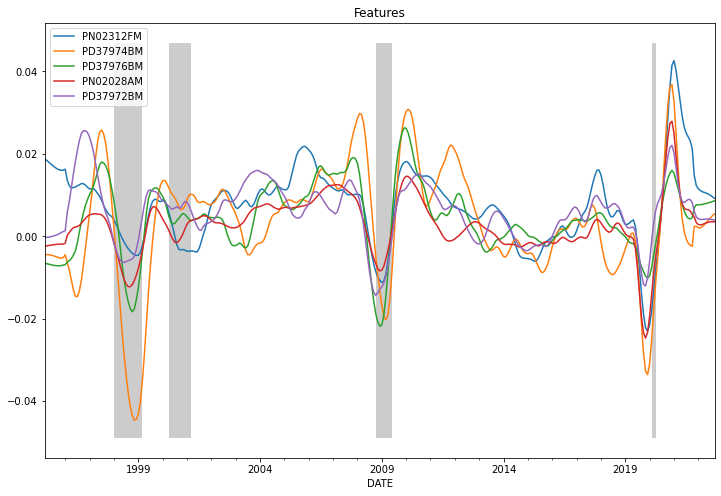

In [6]:
graficarTodo(df,'Features')

# Mostrar Imbalance de clases

In [7]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 331
    Positive: 39 (11.78% of total)



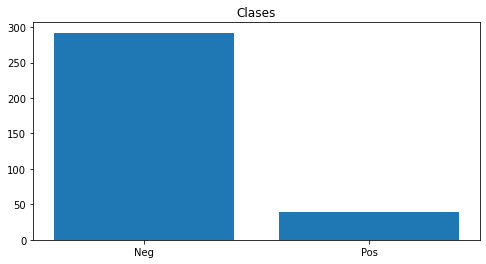

In [8]:
graficarClases(df['Class'])

In [9]:
initial_bias = np.log([pos/neg])

In [10]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 4.24


# Dividir Datos

In [11]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.3)

# Normalizar

In [12]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Fine Tuning

## Modelo

In [13]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def build_mlp(n_steps_in: int, n_features: int, nodes: int,
              layers: int, dropout : float, activation=None, output_bias = None):
    if output_bias is not None:
        output_bias = Constant(output_bias)
    model = Sequential()
    model.add(Flatten(input_shape=(n_steps_in, n_features)))
    for i in range(layers):
        model.add(Dense(nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
    return model

In [14]:
def fine_tuning_model(base_model_path, hp, n_features):
    base_model = load_model(base_model_path)
    #print(base_model.layers[0].input_shape)
    if base_model.layers[0].input_shape[2] == n_features:
        new_model = base_model
        #print(len(new_model.layers))
        for layer in new_model.layers[:-3]:
            layer.trainable = False
    else:
        #Reconstruye el modelo
        new_model = build_mlp(
                n_steps_in = hp['steps_in'],
                n_features = n_features,
                nodes = hp['nodes'],
                layers = hp['layers'],
                dropout = hp['dropout'],
                activation = 'relu',
                output_bias = initial_bias
        )
        for i in range(1,len(base_model.layers)):
            try:
                new_model.layers[0]._batch_input_shape
                new_model.layers[i].set_weights(base_model.layers[i].get_weights())
            except:
                print(f'No se pudo transferir pesos a {new_model.layers[i].name}')

    new_model.compile(optimizer=Adam(learning_rate=1e-3),
                loss=BinaryCrossentropy(), metrics=METRICS)
    return new_model


Variables

In [15]:
n_steps_out = [1,6,12,24]
n_features = len(features)
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
n_epochs = 2000

In [16]:
output_path_model = 'modelos/'
name_prj = 'MLP_TL_PERU_'
N = 20

In [17]:
hps = [
    {'steps_in': 16, 'layers': 3, 'nodes': 224, 'dropout': 0.2},
    {'steps_in': 15, 'layers': 2, 'nodes': 256, 'dropout': 0.4},
    {'steps_in': 13, 'layers': 5, 'nodes': 32, 'dropout': 0.2},
]
base_models = [
    'modelos/MLP_USA_1_20221231_0011_2.h5',
    'modelos/MLP_USA_6_20221231_0011_5.h5',
    'modelos/MLP_USA_12_20221231_0011_6.h5',
]

In [18]:
def entrenar(name_prj, n_steps_out, base_model_path, hp):
    name_prj = name_prj + str(n_steps_out) +'_'+fecha_hora

    # --------------------- Entrenamiento --------------------------------------
    n_steps_in = hp['steps_in']
    x_train, y_train, _ = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
    x_test, y_test, _ = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
    batch_learning = len(x_train)

    prcs = []
    models = []
    res_path = output_path_model+name_prj+".csv"
    print_line("loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc\n",res_path)

    print("Entrenando...")
    for i in range(N):
        name_model = output_path_model+name_prj+'_'+str(i)+'.h5'
        mlp_model = fine_tuning_model(base_model_path, hp, n_features)
        # Condicion de parada: 10 epocas despues del menor val_loss
        es_t = EarlyStopping(
            monitor='precision', 
            verbose=0,
            patience=50,
            mode='max',
            restore_best_weights=True)

        models.append(name_model)
        mlp_model.fit(x=x_train, y=y_train, validation_split = 0.5, epochs = n_epochs
            , verbose = 0, shuffle = False, callbacks = [es_t], 
            batch_size = batch_learning, class_weight = class_weight)

        mlp_model.save(name_model) 
        # --------------------- Evaluacion --------------------------------------
        res = mlp_model.evaluate(x_test, y_test,
                                        batch_size=batch_learning, verbose=0)
        print_line(f'{res[0]},{res[1]},{res[2]},{res[3]},{res[4]},{res[5]},{res[6]},{res[7]},{res[8]},{res[9]}\n', res_path)
        prcs.append(res[6]) #guarda metrica a comparar
    
    #--------- Evaluando el mejor ------------------------
    print("Evaluando mejor...")
    best_model = models[np.argmax(prcs)]
    print(f'\nMejor modelo: {best_model} con precision: {np.max(prcs)}\n')
    for i in range(N):
        if i == np.argmax(prcs):
            continue
        os.remove(models[i])

    mlp_model = load_model(best_model)
    train_predictions = mlp_model(x_train) #, batch_size=batch_learning
    test_predictions = mlp_model(x_test)

    plot_cm(y_test, test_predictions)
    plot_roc(y_train, train_predictions, y_test, test_predictions)
    plot_prc(y_train, train_predictions, y_test, test_predictions)
    plot_probs(y_train, train_predictions, 'Train')
    plot_probs(y_test, test_predictions, 'Test')

# Modelo para 1 mes a futuro

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_TL_PERU_1_20230112_1919_10.h5 con precision: 0.09677419066429138

Expansiones Detectadas (Verdadero Negativos):  52
Expansiones Incorrecas Detectadas (Falso Positivos):  28
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


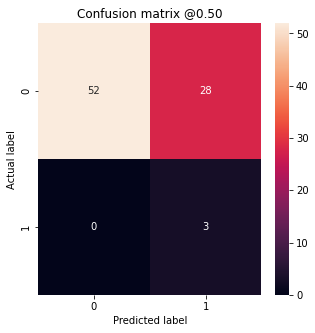

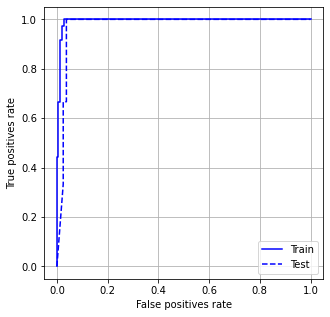

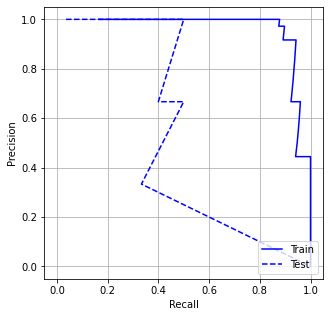

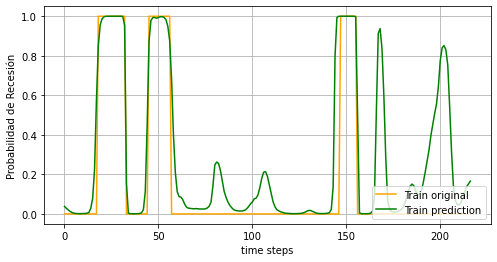

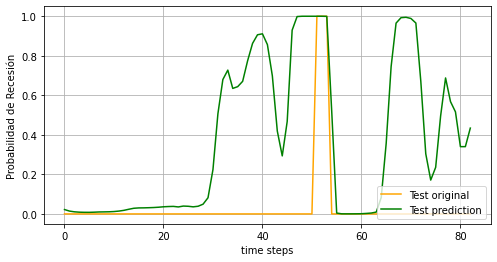

In [19]:
entrenar(name_prj, n_steps_out[0], base_models[0], hps[0])

# Modelo para 6 meses a futuro

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_TL_PERU_6_20230112_1919_8.h5 con precision: 0.6000000238418579

Expansiones Detectadas (Verdadero Negativos):  74
Expansiones Incorrecas Detectadas (Falso Positivos):  2
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


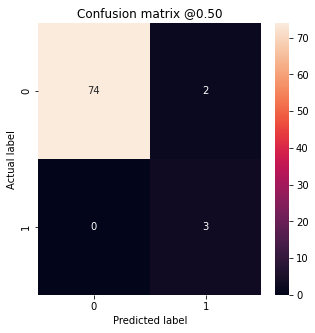

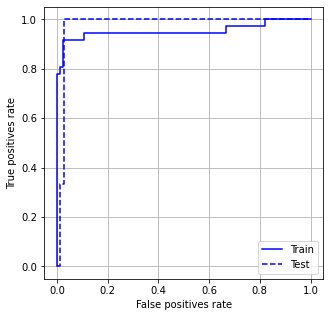

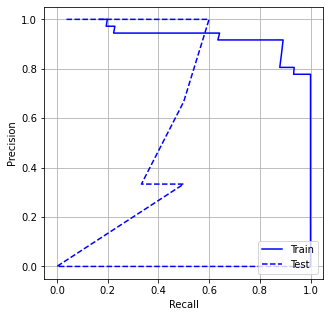

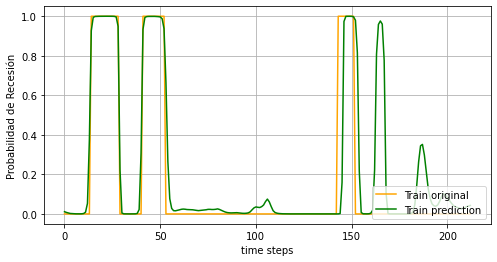

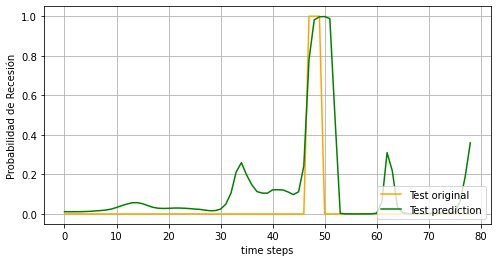

In [20]:
entrenar(name_prj, n_steps_out[1], base_models[1], hps[1])

# Modelo para 12 meses a futuro

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_TL_PERU_12_20230112_1919_0.h5 con precision: 0.0

Expansiones Detectadas (Verdadero Negativos):  26
Expansiones Incorrecas Detectadas (Falso Positivos):  46
Recesiones no Detectadas (False Negativos):  3
Recesiones Detectadas (Verdadero Positivos):  0
Total de Recesiones:  3


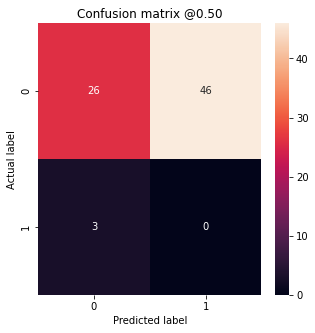

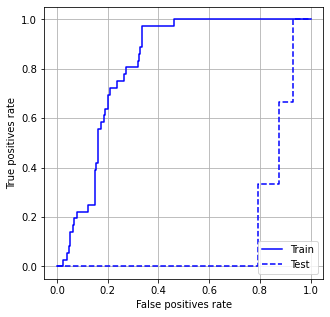

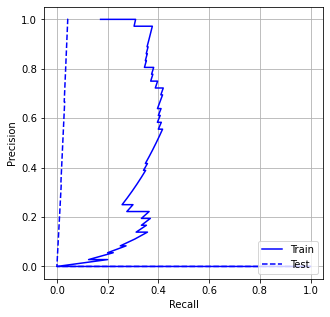

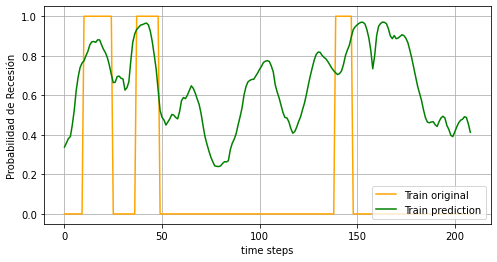

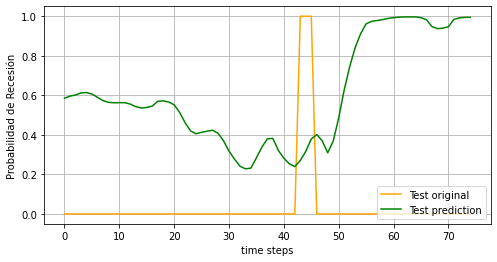

In [21]:
entrenar(name_prj, n_steps_out[2], base_models[2], hps[2])

In [ ]:
from notifications import enviar_correo
subject = 'MLP_TL_PERU hyper finish'
msg = 'Termino la evaluacion'
enviar_correo(subject=subject, msg=msg)